In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np 
import pandas as pd
import pydicom
import os
import shutil
import scipy.ndimage
import matplotlib.pyplot as plt
import seaborn as sns

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
# DICOM IMAGE PROCESSING

In [3]:
BASE_PATH = "/kaggle/input/osic-pulmonary-fibrosis-progression/"
TRAIN_PATH = BASE_PATH + "train/"
TEST_PATH = BASE_PATH + "test/"

train_csv = pd.read_csv(BASE_PATH + "train.csv")
test_csv = pd.read_csv(BASE_PATH + "test.csv")

In [4]:
os.listdir(BASE_PATH)

['train.csv', 'train', 'test.csv', 'test', 'sample_submission.csv']

In [5]:
train_csv

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In [6]:
unique_patients = os.listdir(TRAIN_PATH)
unique_patients.sort()

In [7]:
len(unique_patients)

176

In [8]:
def load_scans(dcm_path):
    slices = [pydicom.dcmread(dcm_path + "/" + file) for file in os.listdir(dcm_path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    return slices

patient0_scans = load_scans(TRAIN_PATH + unique_patients[0])

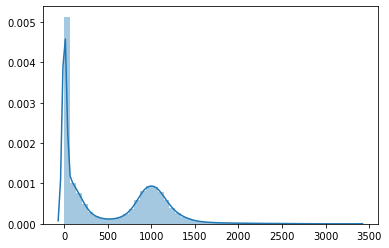

In [9]:
images = np.stack([file.pixel_array for file in patient0_scans])
images = images.astype(np.int16)

images[images <= -1000] = 0

sns.distplot(images)

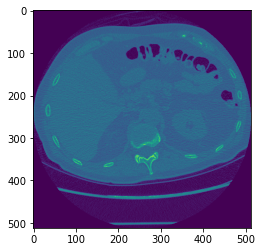

In [10]:
plt.imshow(images[0])
plt.show()

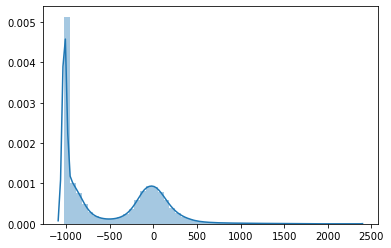

In [11]:
def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    # convert ouside pixel-values to air:
    # I'm using <= -1000 to be sure that other defaults are captured as well
    images[images <= -1000] = 0
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)


patient0_hu = transform_to_hu(patient0_scans)
sns.distplot(patient0_hu)

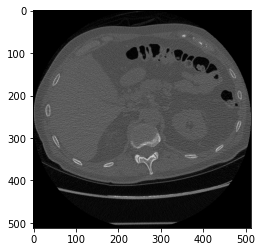

In [12]:
plt.imshow(patient0_hu[0], cmap=plt.cm.gray)
plt.show()

In [ ]:
# PIPELINE (FOR ONE PATIENT) - Can create image dataset using this?!

# image_dataset = {}
# os.mkdir('image_dataset')

for patient_id in unique_patients:
    try:
        patient_scans = load_scans(TRAIN_PATH + patient_id)
        patient_images = transform_to_hu(patient_scans)
    #         image_dataset[patient_id] = patient_images

        np.save('image_dataset/' + str(patient_id) + '.npy', patient_images)
    except:
        pass

# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
# tf.data.Dataset.from_tensor_slices

In [ ]:
os.listdir('image_dataset/')

In [ ]:
## evaluation metric function
def laplace_log_likelihood(actual_fvc, predicted_fvc, confidence, return_values = False):
    """
    Calculates the modified Laplace Log Likelihood score for this competition.
    """
    sd_clipped = np.maximum(confidence, 70)
    delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
    metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

    if return_values:
        return metric
    else:
        return np.mean(metric)


## default benchmark
laplace_log_likelihood(df_train.FVC, np.mean(df_train.FVC), np.std(df_train.FVC))

In [48]:
import tensorflow as tf

filename = '/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00422637202311677017371/45.dcm'
image_bytes = tf.io.read_file(filename)

print(image_bytes)

# image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)
# skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)
# lossy_image = tfio.image.decode_dicom_image(image_bytes, scale='auto', on_error='lossy', dtype=tf.uint8)


# fig, axes = plt.subplots(1,2, figsize=(10,10))
# axes[0].imshow(np.squeeze(image.numpy()), cmap='gray')
# axes[0].set_title('image')
# axes[1].imshow(np.squeeze(lossy_image.numpy()), cmap='gray')
# axes[1].set_title('lossy image')

tf.Tensor(b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00DICM\x02\x00\x00\x00UL\x04\x00\xc8\x00\x00\x00\x02\x00\x01\x00OB\x00\x00\x02\x00\x00\x00\x00\x01\x02\x00\x02\x00UI\x1a\x001.2.840.10008.5.1.4.1.1.2\x00\x02\x00\x03\x00UI,\x002.25.103792236515677438110613049693804268824\x02\x00\x10\x00UI\x14\x001.2.840.10008.1.2.1\x00\x02\x00\x12\x00UI\x1c\x001.2.276.0.7230010.3.0.3.6.1\x00\x02\x00\x13\x00SH\n\x00OSIRIX_361\x02\x00\x16\x00AE\n\x00ANONYMOUS \x08\x00\x05\x00CS\n\x00ISO_IR 100\x08\x00\x08\x00CS\x16\x00ORIGINAL\\PRIMARY\\AXIAL